In [1]:
pip install isodate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:
import pandas as pd
import isodate
import re
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("videos.csv", encoding="utf-8")

In [4]:
df.shape

(92759, 15)

In [5]:
df.isnull().sum()

kind                        0
videoId                     0
publishedAt                 0
channelId                   0
title                       0
description             57522
tags                    71868
defaultLanguage         76974
defaultAudioLanguage    62803
contentDuration          1267
viewCount                1269
likeCount                6129
favouriteCount           1267
commentCount             2465
topicCategories          1531
dtype: int64

#### Categories with null values: 
- description
    - May include some keywords, but since its optional for videos, it may not have a large impact on analysis
- tags
    - Very important for analysis as it includes keywords, but we can remove the null values
    - Can still derive keywords from other variables
- defaultLanguage
    - Can use libraries to identify language used based on the title/description
- defaultAudioLanguage
    - same as defaultLanguage
- contentDuration
    - is a continuous variable, can fill missing values with median
- viewCount/likeCount/favouriteCount/commentCount
    - important metric for analysing engagement/trend identification, drop columns with empty values
- topicCategories
    - can be important, either drop or deduce from video title/description


In [6]:
df_clean = df.dropna(subset=['viewCount','likeCount','favouriteCount','commentCount']).copy()

In [7]:
df_clean.shape

(85683, 15)

- 92759 rows to 85683 rows, 7076 observations deleted

In [8]:
df_clean['contentDuration'].sample(10)

24061      PT27S
37705      PT11S
21418      PT17S
85510      PT32S
13932       PT7S
86821      PT16S
22447    PT6M17S
69028      PT31S
31027      PT30S
39217      PT59S
Name: contentDuration, dtype: object

In [14]:
df_clean.keys()

Index(['kind', 'videoId', 'publishedAt', 'channelId', 'title', 'description',
       'tags', 'defaultLanguage', 'defaultAudioLanguage', 'contentDuration',
       'viewCount', 'likeCount', 'favouriteCount', 'commentCount',
       'topicCategories', 'duration_in_seconds'],
      dtype='object')

"The length of the video. The property value is an ISO 8601 duration. For example, for a video that is at least one minute long and less than one hour long, the duration is in the format PT#M#S, in which the letters PT indicate that the value specifies a period of time, and the letters M and S refer to length in minutes and seconds, respectively. The # characters preceding the M and S letters are both integers that specify the number of minutes (or seconds) of the video. For example, a value of PT15M33S indicates that the video is 15 minutes and 33 seconds long.

If the video is at least one hour long, the duration is in the format PT#H#M#S, in which the # preceding the letter H specifies the length of the video in hours and all of the other details are the same as described above. If the video is at least one day long, the letters P and T are separated, and the value's format is P#DT#H#M#S. Please refer to the ISO 8601 specification for complete details."

In [10]:
df_clean['duration_in_seconds'] = [isodate.parse_duration(d).total_seconds() for d in df_clean['contentDuration']]

In [11]:
df_clean.isnull().sum()

kind                        0
videoId                     0
publishedAt                 0
channelId                   0
title                       0
description             53054
tags                    66890
defaultLanguage         70997
defaultAudioLanguage    57814
contentDuration             0
viewCount                   0
likeCount                   0
favouriteCount              0
commentCount                0
topicCategories           241
duration_in_seconds         0
dtype: int64

The null of these categories should be deduced based off other categories, like "kind", "channelID", and "title". Final df_clean should be extracted into a new csv file for AI modelling. 

In [12]:
df_clean["tags"].sample(20)

22281                                                  NaN
12967    ['makeup', 'makeup videos', 'makeup tutorial v...
84746                                                  NaN
19789                                                  NaN
65747                                                  NaN
1740     ['Curl Hair Without Heat', 'change look withou...
50398                                                  NaN
47188    ['Beginners Makeup', '3 products Makeup', 'Beg...
83650                                                  NaN
62571                                                  NaN
36267                                                  NaN
56555                                                  NaN
4351                                                   NaN
10939                                                  NaN
10558    ['#weightloss', '#cavitation', '#bodycontourin...
43594                                                  NaN
76668                                                  N

In [13]:
df_clean.to_csv('cleaned.csv')

Categories: Sports, Lifestyle, Food, Health, Beauty|

In [49]:
semantic_model = {
    "Skincare": ["skincare", "serum", "moisturizer", "hydration", "acne", "glow"],
    "Fragrance": ["perfume", "fragrance", "cologne", "scent"],
    "Makeup": ["lipstick", "foundation", "eyeshadow", "makeup", "blush", "tutorial"],
    "Haircare": ["shampoo", "conditioner", "hair mask", "haircare", "styling"],
    "Lifestyle": ["vlog", "daily routine", "wellness", "lifestyle","aesthetic"],
    "Sports": ["workout", "upperbody","sports","fitness","weightloss"]
}

In [51]:
def assign_category(row, semantic_model):
    text = " ".join([
        str(row.get("title", "")),
        str(row.get("description", "")),
        " ".join(eval(row.get("tags", "[]"))) if isinstance(row.get("tags"), str) else ""
    ]).lower()
    
    matched_categories = []
    for category, keywords in semantic_model.items():
        for kw in keywords:
            if re.search(rf"\b{kw}\b", text):
                matched_categories.append(category)
                break
    return matched_categories if matched_categories else ["Other"]

df_clean["categories"] = df_clean.apply(assign_category, axis=1, semantic_model=semantic_model)

In [52]:
df_clean['likeRatio'] = df_clean['likeCount']/df_clean['viewCount']
df_clean['commentRatio'] = df_clean['commentCount'] / df_clean['viewCount']
df_clean['SoE'] = (df_clean['likeCount'] + df_clean['commentCount']) / df_clean['viewCount']

In [53]:
df_clean["publishedAt"] = pd.to_datetime(df_clean["publishedAt"])
df_clean["month"] = df_clean["publishedAt"].dt.to_period("M")

trend_df = df_clean.explode("categories").groupby(["month", "categories"]).agg({
    "viewCount": "sum",
    "SoE": "mean"
}).reset_index()

trend_df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11692\2247059903.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_clean["month"] = df_clean["publishedAt"].dt.to_period("M")


,month,categories,viewCount,SoE
0,2020-01,Fragrance,114.0,0.017544
1,2020-01,Haircare,364079.0,0.021988
2,2020-01,Lifestyle,811288.0,0.052503
3,2020-01,Makeup,103765400.0,0.053377
4,2020-01,Other,9224623.0,0.071825


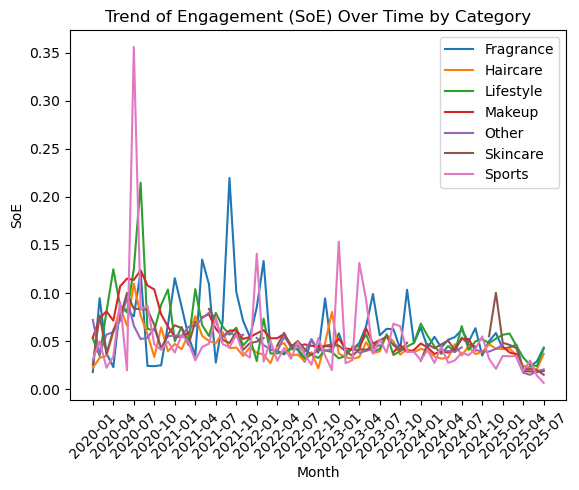

In [54]:
for cat in trend_df["categories"].unique():
    subset = trend_df[trend_df["categories"] == cat]
    plt.plot(subset["month"].astype(str), subset["SoE"], label=cat)

plt.xticks(subset["month"].astype(str)[::3], rotation=45) 
plt.legend()
plt.title("Trend of Engagement (SoE) Over Time by Category")
plt.xlabel("Month")
plt.ylabel("SoE")
plt.show()